In [141]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import Data
import numpy as np
from IPython.display import clear_output
import tqdm

In [142]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [143]:
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('Could not initialize the tensorflow gpu')
    pass


In [144]:
Fa, La, Ia = Data.Make_Dataset(50,0,'Yes')
Fg, Lg, Ig = Data.Make_Dataset(50,0,'No')

Accel
new Data
39
Gyro
new Data
39


In [145]:
from imblearn.over_sampling import SMOTE, ADASYN
La_r = [str(l) for l in La]
Fa_r = Fa.reshape(Fa.shape[0], 150)
X_resampled, y_resampled = SMOTE().fit_resample(Fa_r,La_r)
X_resampled.shape

(9945, 150)

In [146]:
Fa_r_r = X_resampled.reshape(9945,50,3,1)

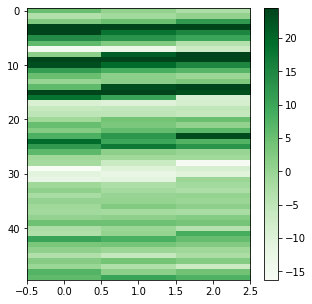

In [147]:
plt.figure(figsize = (5,5))
plt.imshow(Fa_r_r[165], interpolation='nearest', aspect='auto', cmap= 'Greens')
plt.colorbar()
plt.show()
%matplotlib inline

In [148]:
Fg[165].shape

(3, 50, 1)

In [149]:
La[165]

6.0

In [150]:
BUFFER_SIZE = Fa.shape[0]
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(Fa).shuffle(BATCH_SIZE)


# Discriminator Model

In [151]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(3,50,1)))
    model.add(tf.keras.layers.Conv2D(7, (3,3), padding = "same"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50*2, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [152]:
model_discriminator = make_discriminator_model()
model_discriminator(np.random.randn(1,3,50,1).astype('float32'))


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.08018634]], dtype=float32)>

In [153]:
model_discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 3, 50, 7)          70        
_________________________________________________________________
flatten_5 (Flatten)          (None, 1050)              0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1050)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               105100    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 105,271
Trainable params: 105,271
Non-trainable params: 0
_________________________________________________________________


In [154]:
discriminator_optimizer = tf.optimizers.Adam(1e-3)
generator_optimizer = tf.optimizers.Adam(1e-3)

In [155]:
def get_discriminator_loss(real_predictions, fake_predictions):
    real_preds = tf.sigmoid(real_predictions)
    fake_preds = tf.sigmoid(fake_predictions)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_preds), real_preds)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_preds), fake_preds)
    return (real_loss+fake_loss)/2

# Generator

In [156]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(3*50*3, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization())
    print(model.output_shape)
    model.add(tf.keras.layers.Dense(3*50*1, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization())
    print(model.output_shape)
    model.add(tf.keras.layers.Reshape((3,50,1)))
    print(model.output_shape)
    model.add(tf.keras.layers.Conv2DTranspose(6, (3,3), padding = 'same'))
    print(model.output_shape)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(4, (3,3),strides = (1,1), padding = 'same'))
    print(model.output_shape)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3),strides = (1,1), padding = 'same'))
    print(model.output_shape)
    return model

In [157]:
generator = make_generator_model()
generator.summary()

(None, 450)
(None, 150)
(None, 3, 50, 1)
(None, 3, 50, 6)
(None, 3, 50, 4)
(None, 3, 50, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 450)               45450     
_________________________________________________________________
batch_normalization_17 (Batc (None, 450)               1800      
_________________________________________________________________
dense_20 (Dense)             (None, 150)               67650     
_________________________________________________________________
batch_normalization_18 (Batc (None, 150)               600       
_________________________________________________________________
reshape_5 (Reshape)          (None, 3, 50, 1)          0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 3, 50, 6)          60        
___________________________

In [158]:
model_discriminator(generator(np.random.randn(10,100)))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.0614004 ],
       [-0.10231433],
       [-0.02739333],
       [ 0.03744532],
       [-0.07455835],
       [-0.06257272],
       [-0.01289695],
       [-0.04766909],
       [ 0.08908349],
       [-0.01363639]], dtype=float32)>

In [159]:
def get_generator_loss(fake_predictions):
    fake_preds = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_preds), fake_preds)
    return fake_loss

# Training


In [160]:
def train(dataset, epochs):
    for _ in range(epochs):
        for datum in tqdm.tqdm(dataset):
            datum = tf.cast(datum, tf.dtypes.float32)
            datum = tf.reshape(datum,(1,3,50,1))
            #print(datum.shape)
            train_step(datum)

In [161]:
def train_step(datum):
    #fake_datum_noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
    fake_datum_noise = np.random.randn(1,100).astype('float32')
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        discriminator_optimizer = tf.optimizers.Adam(1e-3)

        generated_datum = generator(fake_datum_noise)
        #print(generated_datum)
        real_output = model_discriminator(datum)
        fake_output = model_discriminator(generated_datum)
       
        gen_loss = get_generator_loss(fake_output)
        disc_loss = get_discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #print(gradients_of_generator[0].shape)
    #print(generator.variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)
    #print(gradients_of_discriminator[0].shape)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))
    
    print("generated loss : ", np.mean(gen_loss))
    print("discriminator loss : ", np.mean(disc_loss))
    clear_output(wait=True)


In [162]:
train(train_dataset, 1)

6942it [03:01, 38.19it/s]


In [22]:
# Fa_samples = tf.reshape(Fa,(6942,50,3,1))
# #train_images_samples = (tf.cast(train_images_samples,dtype=tf.dtypes.float32)-127.5)/127.5
# fake_fa = generator(np.random.rand(500,100))

# real_predictions = make_discriminator_model()
# fake_predictions = make_discriminator_model(fake_fa)

# disc_loss = get_discriminator_loss(real_predictions,fake_predictions)
# disc_grad = disc_tape.gradient(disc_loss,discriminator_model.variables)

# gen_loss = get_generator_loss(fake_predictions)
# gen_grad = gen_tape.gradient(gen_loss,generator.variables)

# discriminator_optimizer.apply_gradients(zip(disc_grad,discriminator_model.variables))
# generator_optimizer.apply_gradients(zip(gen_grad,generator.variables))
# print(disc_grad,discriminator_model.variables)

In [233]:
data = generator(np.random.randn(1,100)).numpy().reshape(3,50)

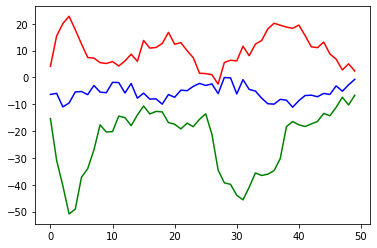

In [234]:
colors = ['Greens', 'Reds']
lineColors = ['Red', 'Green', 'Blue']
labels = ['Accel','Gyro']
# fig,axs = plt.subplots(2,2)
# instance = 19
# for i,F in enumerate([Fa,Fg]):
#     ax = axs[i,0]
#     pcm = ax.imshow(F[instance], interpolation='nearest', aspect='auto', cmap=colors[i])
#     fig.colorbar(pcm, ax=ax)
#     #pcm.set_ylabel(labels[i])
#   #  ax.set_yticks([1,2,3])
#    # ax.set_yticklabels(['z','y','x'])
    
for j in range(3):
    plt.plot(data[j], color = lineColors[j])

plt.show()
%matplotlib inline